### Recurrent Neural Network representation of C. elegans neural timeseries data
Script to model C. elegans neural timeseries data,
and generate similar data, using a Recurrent
Neural Network (specifically, a long short term memory or LSTM network)

Inspired by
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

Based on code from
https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py

In [1]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import os

%matplotlib inline
import matplotlib.pyplot as plt

os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

#Add the src folder to the sys.path list
sys.path.append('../src/')
import data_config as dc

/Users/akivalipshitz/Developer/neuronal-analysis/data/wbdata/


Using Theano backend.


In [2]:
wormData = dc.kato.data()
wormData

,0,1,2,3,4
FlNm,TS20140715f_lite-1_punc-31_NLS3_3eggs_56um_1mM...,TS20140926d_lite-1_punc-31_NLS3_RIV_2eggs_1mMT...,TS20141221b_THK178_lite-1_punc-31_NLS3_6eggs_1...,TS20140715e_lite-1_punc-31_NLS3_2eggs_56um_1mM...,TS20140905c_lite-1_punc-31_NLS3_AVHJ_0eggs_1mM...
NeuronIds,0 1 0 None None 1 None ...,0 1 0 None None 1 None...,0 1 0 None None 1 None ...,0 1 2 0 None None Non...,0 1 0 NaN NaN 1 NaN Na...
deltaFOverF,"[[0.135913490458, 0.122698371026, 0.1273345364...","[[-0.0888920088322, -0.130398703723, -0.080847...","[[-0.15780023438, -0.119564953505, -0.18563226...","[[0.122448621446, 0.118398218526, 0.1275767208...","[[0.150902719177, -0.039497701204, 0.045866099..."
deltaFOverF_bc,"[[0.0813810375536, 0.068289481621, 0.073049190...","[[0.11694110675, 0.0756448955127, 0.1254065656...","[[0.102359940819, 0.141055885003, 0.0754484136...","[[0.0686293468348, 0.0647636490109, 0.07412679...","[[0.230656610926, 0.0403072988817, 0.125722194..."
deltaFOverF_deriv,"[[-0.000551819232698, -0.000551818672615, -0.0...","[[0.0062459423014, 0.00624604574426, 0.0062471...","[[-0.000489274045825, -0.000489858006098, -0.0...","[[0.000883089395239, 0.000883089373364, 0.0008...","[[-0.0309526801435, -0.0309354939679, -0.02839..."
tv,"[[0.0, 0.344607530313, 0.689215060625, 1.03382...","[[0.0, 0.326185442465, 0.652370884929, 0.97855...","[[0.0, 0.357497517378, 0.714995034757, 1.07249...","[[0.0, 0.344277972585, 0.688555945171, 1.03283...","[[0.0, 0.35305655443, 0.706113108859, 1.059169..."


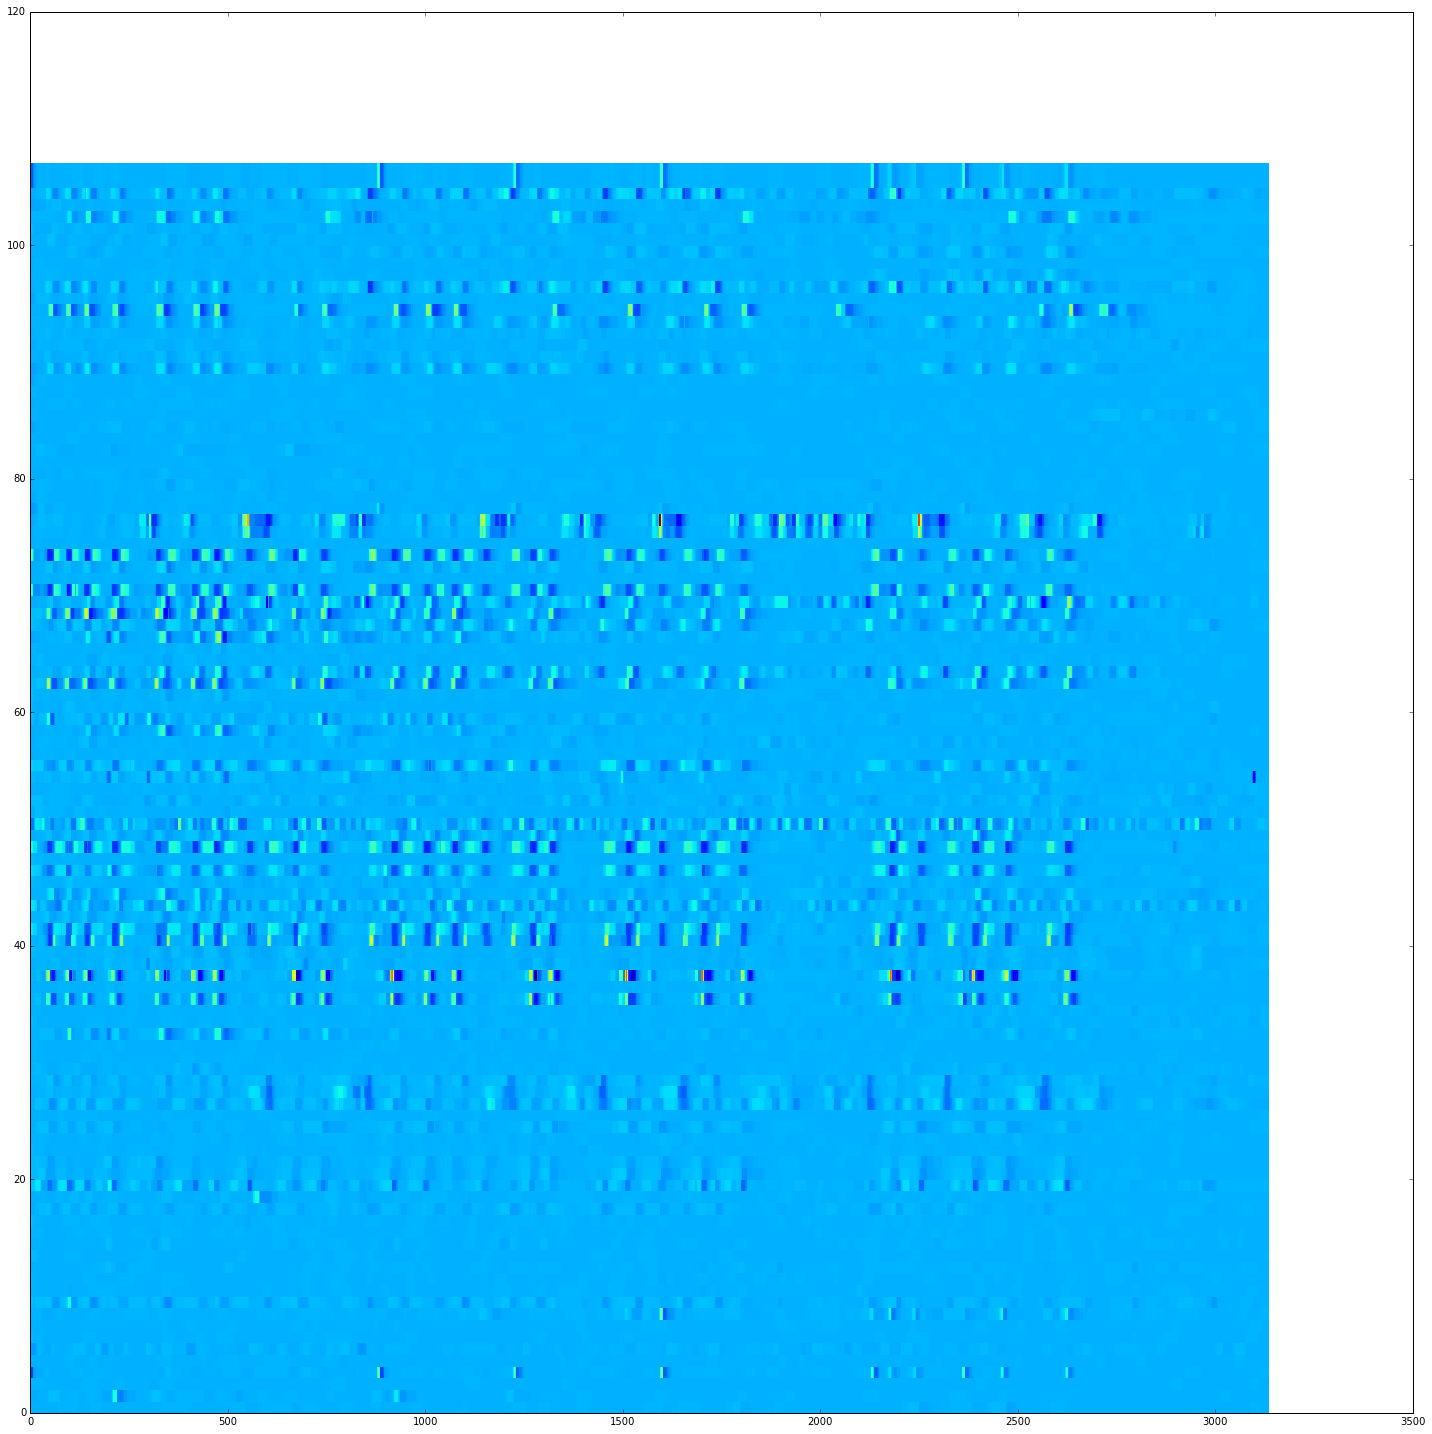

In [4]:
# Choose a trial arbitrarily
# Let's try with derivative data

seq = wormData[0]["deltaFOverF_deriv"].T
plt.figure(figsize=(20,20))
plt.pcolormesh(1000*seq.T)
plt.tight_layout()


In [5]:
# Cut the timeseries data (variable name 'seq') into semi-redundant sequence chunks of slidingwindowsize
slidingwindowsize = 50

X = []
y = []

for i in range(0, len(seq) - slidingwindowsize):
    X.append(seq[i:i+slidingwindowsize])
    y.append(seq[i+slidingwindowsize])

dim = len((X[0][0]))

print("sequence chunks:", len(X))
print("chunk width:", len(X[0]))
print("vector dimension:", dim)

X = np.array(X)
y = np.array(y)

('sequence chunks:', 3084)
('chunk width:', 50)
('vector dimension:', 107)


In [ ]:
# build the model: 2 stacked LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(slidingwindowsize, dim)))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(dim))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

Build model...


In [ ]:

# We're building a sliding window predictor,
# with a window of slidingwindowsize. 
# In the future, we can generate probability distributions and
# sample from that. 

# We can also build markov matrices on the data – I'm not sure where that direction will take us?

model.fit(X, y, batch_size=500, nb_epoch=3)

In [24]:
# Generate timeseries
x_seed = X[len(X)-1] #choose final in-sample data point to initialize model
x_array = []
x_array.append(x_seed)
x = np.array(x_array)

generated = []
for i in range(50):
    pred = model.predict(x, verbose=0)[0].tolist()

    #drop oldest data in x, and append predicted data for feedforward into model
    j = []
    x = []
    for i in range(1, len(x_seed)):    
        j.append(x_seed[i])
    j.append(pred)
    x = []
    x.append(j)
    x = np.array(x)
    generated.append(pred)

generated = np.array(generated)

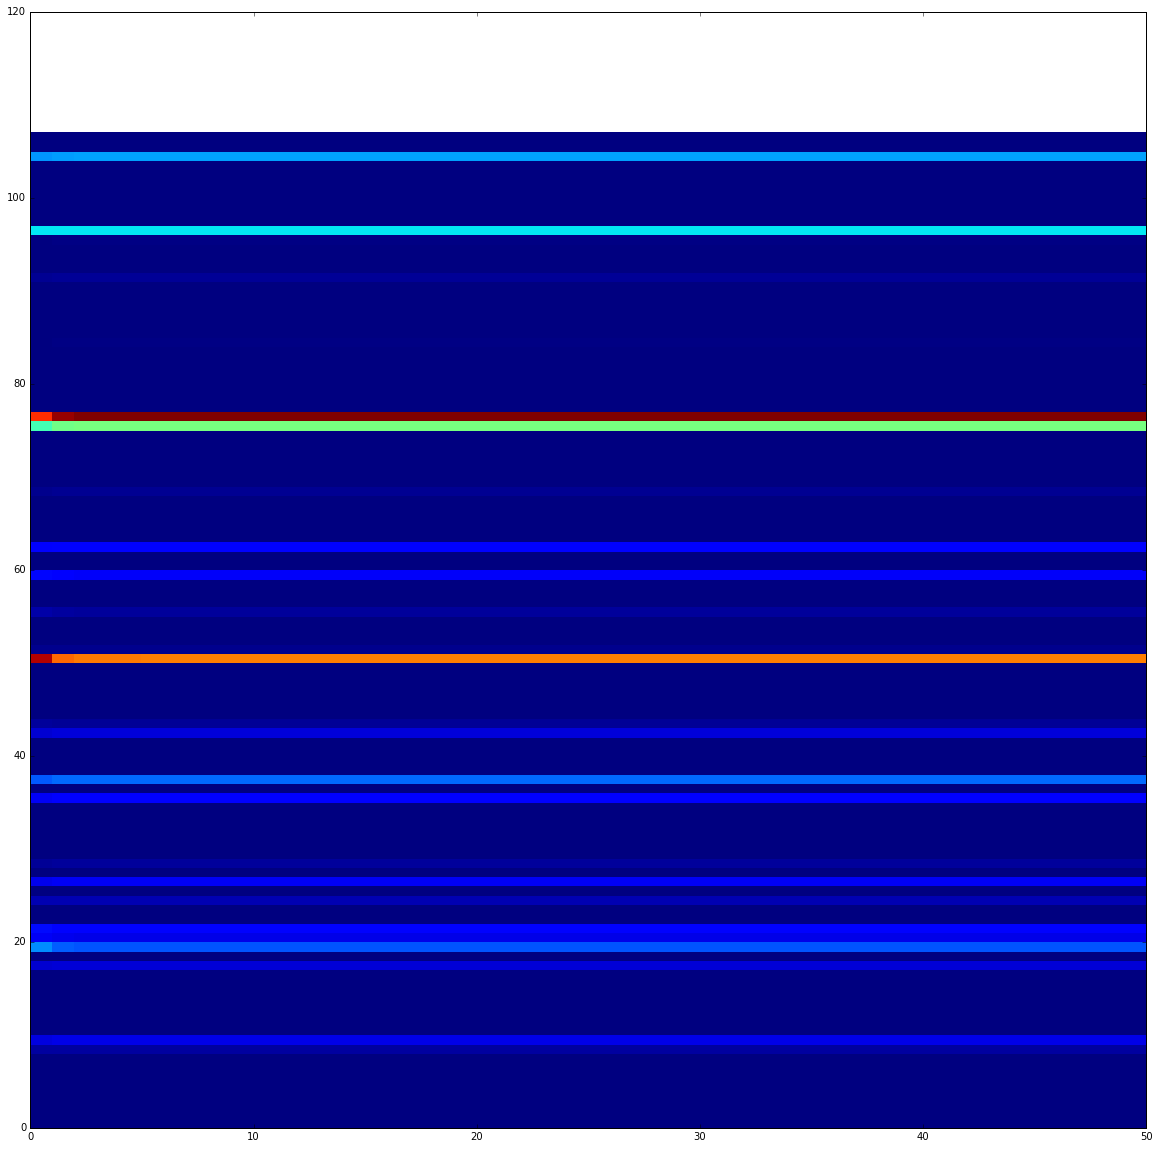

In [33]:
plt.figure(figsize=(20,20))
plt.pcolor(generated.T)